In [1]:
# Se importan las librerias necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from tqdm import tqdm

## Procesamiento de los datos

In [2]:
#Lectura de los archivos previamente limpiados
Sales = pd.read_csv("D:\Sexto Semestre\Datathon Viva\Flight_ProductSales.csv")

In [3]:
#Se visualiza la distribucion de los datos
Sales.head()

,Unnamed: 0,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,ArrivalCentral,DepartureCentral,ProductType,ProductName,Quantity,TotalSales
0,0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,0,1,Galletas,Chokis,1,45.0
1,1,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,0,1,Refrescos,Sprite,1,48.0
2,2,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,0,1,Licores,Amstel Ultra,2,144.0
3,3,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,0,1,Bebidas Calientes,Cafe 19 Capuchino,1,45.0
4,4,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,0,1,Botanas,Mafer Sin Sal,1,45.0


In [4]:
# Se agregan algunas columnas necesarias, que nos permitiran discretizar las columnas continuas
Sales.drop(columns="Unnamed: 0", inplace=True)
Sales["STD"] = pd.to_datetime(Sales["STD"])
Sales["STA"] = pd.to_datetime(Sales["STA"])

Sales["FlightDuration"] = (Sales["STA"]-Sales["STD"]) / pd.Timedelta(minutes=1)
Sales["Hour"] = Sales["STD"].dt.hour 
Sales["WeekDay"] = Sales["STD"].dt.weekday
Sales["Day"] = Sales["STD"].dt.day
Sales["Month"] = Sales["STD"].dt.month

Sales = Sales[(Sales["FlightDuration"]>45) & (Sales["FlightDuration"]<(8*60))]

In [5]:
# Se generan Bins, que nos permiten clasificar ciertos intervalos de tiempo, como pertenecientes a una clase
bins = [-1, 8, 16, 25]
names = ['Madrugada', 'Dia', 'Tarde-Noche']
Sales['Horario'] = pd.cut(Sales['Hour'], bins, labels=names)

bins = [-1, 10, 20, 32]
names = ['Principios', 'Mediados', 'Fines']
Sales["MonthPeriod"] = pd.cut(Sales['Month'], bins, labels=names)

bins = [-1, 4, 8]
names = ["Entre Semana", 'Fin de Semana']
Sales["WeekPeriod"] = pd.cut(Sales['WeekDay'], bins, labels=names)

In [6]:
# Se crean una copia para trabajar con la modelacion de pasajeros
CSPassanger = Sales.copy()

In [7]:
# Se tiran aquellas columnas que no resultan de interes como predictores en el modelo de pasajeros 
ColumnasTirarP =['Flight_ID','Aeronave','Bookings',
                'TotalSales','ArrivalCentral', 'DepartureCentral','ProductType', "STD", "STA","ProductName","Quantity"]
CSPassanger.drop(columns=ColumnasTirarP, inplace=True)
CSPassanger = CSPassanger.drop_duplicates()

In [8]:
# Se reinicia el indicie
CSPassanger.reset_index(inplace=True)
CSPassanger.drop(columns="index",inplace=True)

## Modelo Pasajeros con GBR

In [9]:
# Ya que nuestro entregable principal es una simulacion de montecarlo, se realizo un ejemplo de un posible 
# modelo predictor, que si bien da una prediccion aproximada, nos permite darnos cuenta que esta clase de modelos,
# no son la mejor manera de resolver esta clase de problemas


#Se escalan los valores numericos y se les hace un OneHotEncoding a los categoricos
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
CSPassanger[["Capacity"]] = scaler.fit_transform(CSPassanger[["Capacity"]])
CSPassanger[["Passengers"]] = scaler1.fit_transform(CSPassanger[["Passengers"]])
CSPassanger[["FlightDuration"]] = scaler2.fit_transform(CSPassanger[["FlightDuration"]])
CSPassanger["Month"] = CSPassanger["Month"].astype(str)
CSPassanger = pd.get_dummies(CSPassanger, prefix=['DepartureStation', 'ArrivalStation','Destination_Type', 'Origin_Type','Month', 'Horario', 'MonthPeriod', 'WeekPeriod'], dtype=float)

# Se separan las variables entre predictora y objetivo, para hacer el respectivo traintest split
CSPy = CSPassanger.pop("Passengers")
CSPassanger = CSPassanger.drop(columns=["Hour", "WeekDay", "Day"])
X_train, X_test, y_train, y_test = train_test_split(CSPassanger, CSPy, test_size=0.2, random_state=42)

In [10]:
# Se importan las librerias correspondientes al modelo de Regresion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# Se plantean los parametros, tasa de aprendizaje, al igual que una semilla aleatoria para que los
# resultados sean replicables 
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# Se calcula una primera medida de error, la cual aparenta ser buena, pero resulta necesario comprobar este error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.010446202933784945


In [11]:
# Para comprobar, se utilizaron diversas metricas de precision para regresiones, algo que cabe destacar
# Es que se calcularon los errores sobre los valores no escalados.
y_test_original = scaler.inverse_transform(y_test.to_frame()) 
y_pred_original = scaler.inverse_transform(pd.DataFrame(y_pred, columns=["Pasajero"])) 

# Mean Absolute Error
mae = mean_absolute_error(y_test_original, y_pred_original)

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

#  R-squared (R2) score
r2 = r2_score(y_test_original, y_pred_original)

# Como se puede observar, si bien los errores son pequeños, el R^2  no es el mejor, y nos indica un ajuste medianamente bueno del sistema
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 0.010446202933784945
Mean Absolute Error (MAE): 4.816141151177841
Root Mean Squared Error (RMSE): 6.336813400871871
R-squared (R2) Score: 0.4566297215217221


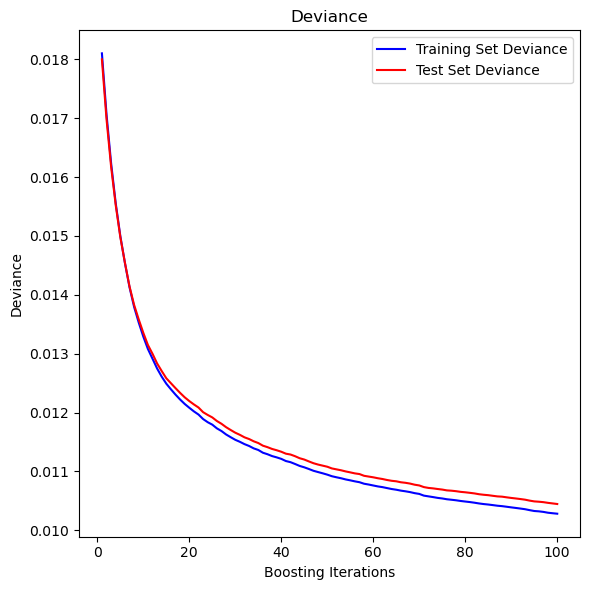

In [12]:
# Se grafica la deviacion de nuestro modelo (algo util para los GBR), como podemos observar el training y el test estan cerca,
# indicando (para un GBR) que el modelo es bueno
test_score = np.zeros((100,), dtype=np.float64)
for i, y_pred in enumerate(gb.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(100) + 1,
    gb.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(100) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

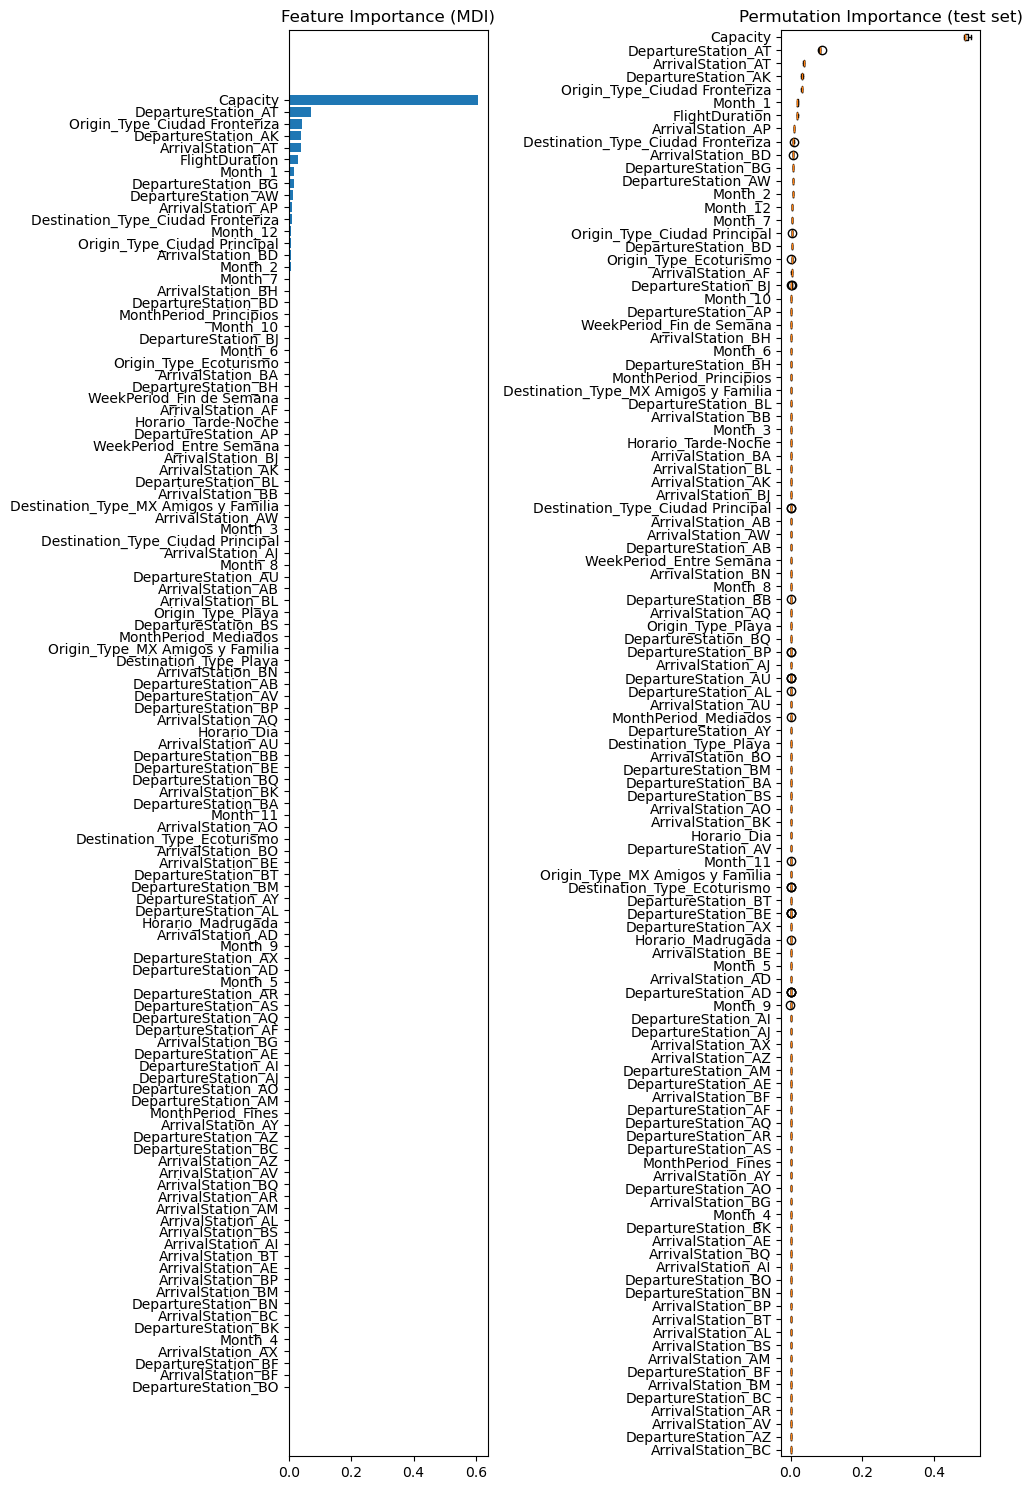

In [13]:
# En las siguientes graficas se muestran aquellas caracteristicas a las que el modelo les da mas importancia, 
# Aqui podemos observar y concluir, que apesar del mal R^2, el modelo tiene un error aceptable, dado que este
# Utiliza la capacidad del avion como principal peso para la regresion.

# Esto muy probablemente se debe a que los vuelos casi siempre van llenos, por lo que el siempre apuntar por
# Una prediccion alta, resulta en una penalizacion baja para el modelo, es decir que si predice el comportamiento
# General de los vuelos, pero ignora aquellas situaciones que resultan en una cantidad baja de pasajeros.

feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(CSPassanger.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(CSPassanger.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

## Predicciones de Enero 2024

In [14]:
# En esta seccion se replico la limpieza de los datos, pero en este caso para 2024 para realizar, las predicciones
# de un mes del presente año
sales2024 = pd.read_csv("D:\Sexto Semestre\Datathon Viva\Flight_ProductSales2024 (1).csv")
del(sales2024["Unnamed: 0"])
sales2024 = sales2024.sort_values("STD").reset_index().drop(columns="index")

C:\Users\jmanu\AppData\Local\Temp\ipykernel_21272\3483784374.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  sales2024 = pd.read_csv("D:\Sexto Semestre\Datathon Viva\Flight_ProductSales2024 (1).csv")


In [15]:
# Limpieza que es igual al input del modelo
sales2024["STD"] = pd.to_datetime(sales2024["STD"])
sales2024["STA"] = pd.to_datetime(sales2024["STA"])
sales2024["FlightDuration"] = (sales2024["STA"]-sales2024["STD"]) / pd.Timedelta(minutes=1)
sales2024["Hour"] = sales2024["STD"].dt.hour 
sales2024["WeekDay"] = sales2024["STD"].dt.weekday
sales2024["Day"] = sales2024["STD"].dt.day
sales2024["Month"] = sales2024["STD"].dt.month
sales2024 = sales2024[(sales2024["FlightDuration"]>45) & (sales2024["FlightDuration"]<(8*60))]
sales2024DateFilter = sales2024.copy()

ColumnasTirarP =["Parejas",'Aeronave','Bookings','TotalSales','ArrivalCentral', 'DepartureCentral','ProductType', "STD", "STA","ProductName","Quantity"]
sales2024.drop(columns=ColumnasTirarP, inplace=True)

bins = [-1, 8, 16, 25]
names = ['Madrugada', 'Dia', 'Tarde-Noche']
sales2024['Horario'] = pd.cut(sales2024['Hour'], bins, labels=names)

bins = [-1, 10, 20, 32]
names = ['Principios', 'Mediados', 'Fines']
sales2024["MonthPeriod"] = pd.cut(sales2024['Month'], bins, labels=names)

bins = [-1, 4, 8]
names = ["Entre Semana", 'Fin de Semana']
sales2024["WeekPeriod"] = pd.cut(sales2024['WeekDay'], bins, labels=names)
sales2024 = sales2024.drop(columns=["Hour", "WeekDay", "Day"])

sales2024[["Capacity"]] = scaler.fit_transform(sales2024[["Capacity"]])
sales2024["Passengers"] = sales2024["Passengers"].fillna(0)
sales2024[["FlightDuration"]] = scaler2.fit_transform(sales2024[["FlightDuration"]])
sales2024["Month"] = sales2024["Month"].astype(str)
sales2024 = sales2024.drop(columns=["Flight_ID","Passengers"])
sales2024 = pd.get_dummies(sales2024, ['DepartureStation', 'ArrivalStation','Destination_Type', 'Origin_Type','Month', 'Horario', 'MonthPeriod', 'WeekPeriod'], dtype=float)

In [16]:
# Se toma solo el mes de enero de 2024 para predecir la cantidad de pasajeros en cada vuelo, con el fin de que el comite pueda comparar los resultados con los valores verdaderos
sales2024valores = sales2024DateFilter[(sales2024DateFilter["STD"] >= '2024-01-01') & (sales2024DateFilter["STD"]<='2024-01-31')]
saledic2024 = sales2024.filter(items = sales2024valores.index, axis=0)
saledic2024.drop(inplace=True,columns=["ArrivalStation_AS"])
sales2024valores["Passengers"]=scaler1.inverse_transform(pd.DataFrame(gb.predict(saledic2024))).round()

C:\Users\jmanu\AppData\Local\Temp\ipykernel_21272\698298672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales2024valores["Passengers"]=scaler1.inverse_transform(pd.DataFrame(gb.predict(saledic2024))).round()


In [17]:
# Para realizar la comparacion se recomienda el uso de la columna de Flight_ID
sales2024valores.head()

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,...,Parejas,ProductType,ProductName,Quantity,TotalSales,FlightDuration,Hour,WeekDay,Day,Month
0,5af600e8e3131804971e9764659a4e50,XA-VIY,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2024-01-01 00:05:00,2024-01-01 05:05:00,186.0,145.0,...,"('BM', 'AV')",NaN,NaN,NaN,NaN,300.0,0,0,1,1
1,aa14abe062912b5497a400a8f3473407,XA-VBT,BM,AO,Ciudad Principal,Ciudad Fronteriza,2024-01-01 00:30:00,2024-01-01 05:25:00,220.0,167.0,...,"('BM', 'AO')",NaN,NaN,NaN,NaN,295.0,0,0,1,1
2,803b0d7b2c8ae03f9f098eb1686d683a,XA-VXJ,BM,BB,Ecoturismo,Ciudad Fronteriza,2024-01-01 00:55:00,2024-01-01 06:40:00,240.0,155.0,...,"('BM', 'BB')",NaN,NaN,NaN,NaN,345.0,0,0,1,1
3,26a1ddf4c763fc84f7734ef5308cf6de,XA-VAP,BM,BA,Ciudad Principal,Ciudad Fronteriza,2024-01-01 01:00:00,2024-01-01 06:15:00,186.0,136.0,...,"('BM', 'BA')",NaN,NaN,NaN,NaN,315.0,1,0,1,1
4,479ec62310c8a89c85914816e29e81ec,XA-VAA,BM,AD,MX Amigos y Familia,Ciudad Fronteriza,2024-01-01 01:00:00,2024-01-01 05:50:00,186.0,145.0,...,"('BM', 'AD')",NaN,NaN,NaN,NaN,290.0,1,0,1,1
